In [69]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as MSE 
import local_python_packages.features_adding as local

In [2]:
pd.set_option('display.max_columns', None)
flights_data = pd.read_csv('All flights 2019_final.csv',parse_dates=[0])
flights_data = flights_data.sort_values(['fl_date'])

In [3]:
df_weather = pd.read_csv('cities_and_dates_weather_final.csv',parse_dates=[1])

In [4]:
df_holidays = pd.read_csv('US holidays.csv',parse_dates=[0])

In [5]:
flights_data['arr_delay_Yes/No'] = 0

In [6]:
flights_data.loc[ flights_data['arr_delay']>0 , 'arr_delay_Yes/No'] = 1

Adding additional columns from our feature engineering

In [7]:
flights_data = local.add_taxi_Ndays_rolling(flights_data, 7, 7)

In [8]:
flights_data = local.add_traffic_rolling(flights_data, 7, 7)

In [9]:
flights_data = local.make_month_dummies(flights_data, 'fl_date')

In [10]:
flights_data = local.merging_weather_flights(flights_data,df_weather)

In [11]:
flights_data = local.add_dep_delay_Ndays_rolling(flights_data, 7, 7)

In [12]:
flights_data = local.add_dep_delay_Ndays_roll_per_tail_num(flights_data, 7, 7)

In [13]:
flights_data = local.add_US_holidays(flights_data, df_holidays)

In [14]:
flights_data = local.make_dates_ordinal(flights_data, 'fl_date')

In [15]:
flights_data = local.add_arr_delay_Ndays_roll(flights_data, 7, 7, ['origin_airport_id', 'dest_airport_id', 'tail_num',
                                                                   'mkt_carrier_fl_num' ])

In [16]:
flights_data = local.add_polynomial_features(flights_data)

In [17]:
features_list = [
        #From initial dataset
        'fl_date', 'arr_delay_Yes/No', 'crs_elapsed_time','air_time', 'distance',
        
        #From add_taxi_Ndays_rolling function
       '7d taxi_out by origin_airport_id', '7d taxi_in by dest_airport_id', 
        '7d taxi_out by mkt_carrier_fl_num', '7d taxi_in by mkt_carrier_fl_num',
        
        #From add_traffic_rolling function
       '7d roll flts origin_airport_id', '7d roll flts dest_airport_id',
        
        #From make_month_dummies function
       'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 
        'month_6','month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12',
        
        #From merging_weather_flights function
       'origin_city_wspd', 'origin_visibility',
       'dest_city_wspd', 'dest_visibility',
        'origin_cond_Overcast', 'origin_cond_Partially cloudy', 'origin_cond_Rain', 'origin_cond_Snow',
       'dest_cond_Overcast', 'dest_cond_Partially cloudy', 'dest_cond_Rain','dest_cond_Snow',
        'origin_wspd/visib', 'dest_wspd/visib',
        
        #From add_US_holidays function
        'Type_Federal holiday',
        
        #From add_dep_delay_Ndays_rolling function
        '7 days roll dep_delay', 
        
        #From add_dep_delay_Ndays_roll_per_tail_num function
        '7 days roll dep_delay_per_tail_num',
        
        #From add_polynomial_features function
        'dest_air X date' , 'orig_air X date',
        'mkt_carrier_fl_num X date', 'tail_num X date',
        'tail_num X dest airport', 'tail_num X origin airport',  'mkt_carrier X dest_airport', 'mkt_carrier X origin_airport',
        '7d roll taxi_out X tail_num', '7d roll taxi_in X tail_num',
        
        #From add_arr_delay_Ndays_roll function
        '7 days roll arr_delay_per_origin_airport_id', '7 days roll arr_delay_per_dest_airport_id', 
        '7 days roll arr_delay_per_tail_num', '7 days roll arr_delay_per_mkt_carrier_fl_num']

In [18]:
#flights_data = local.replace_nan_with_mean(flights_data, 'arr_delay')

In [19]:
flights_data.head()

,fl_date,mkt_carrier,mkt_carrier_fl_num,tail_num,op_carrier_fl_num,origin_airport_id,origin,origin_city_name,dest_airport_id,dest,dest_city_name,crs_dep_time,dep_time,dep_delay,taxi_out,wheels_off,wheels_on,taxi_in,crs_arr_time,arr_time,arr_delay,cancelled,cancellation_code,diverted,dup,crs_elapsed_time,actual_elapsed_time,air_time,flights,distance,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,first_dep_time,total_add_gtime,longest_add_gtime,no_name,arr_delay_Yes/No,7d taxi_out by origin_airport_id,7d taxi_in by dest_airport_id,7d taxi_out by mkt_carrier_fl_num,7d taxi_in by mkt_carrier_fl_num,7d roll flts origin_airport_id,7d roll flts dest_airport_id,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,origin_city_wspd,origin_visibility,origin_wspd/visib,dest_city_wspd,dest_visibility,dest_wspd/visib,origin_cond_Overcast,origin_cond_Partially cloudy,origin_cond_Rain,origin_cond_Snow,dest_cond_Overcast,dest_cond_Partially cloudy,dest_cond_Rain,dest_cond_Snow,7 days roll dep_delay,7 days roll dep_delay_per_tail_num,Type_Federal holiday,7 days roll arr_delay_per_origin_airport_id,7 days roll arr_delay_per_dest_airport_id,7 days roll arr_delay_per_tail_num,7 days roll arr_delay_per_mkt_carrier_fl_num,orig_air X date,dest_air X date,mkt_carrier_fl_num X date,tail_num X date,tail_num X dest airport,tail_num X origin airport,mkt_carrier X dest_airport,mkt_carrier X origin_airport,7d roll taxi_out X tail_num,7d roll taxi_in X tail_num
0,737060,UA,3683,N751YX,3683,13487,MSP,"Minneapolis, MN",12266,IAH,"Houston, TX",530,527.0,-3.0,31.0,558.0,842.0,8.0,835,850.0,15.0,0.0,NaN,0.0,N,185.0,203.0,164.0,1.0,1034.0,0.0,0.0,15.0,0.0,0.0,NaN,NaN,NaN,NaN,1,16.347962,6.023810,21.988095,11.142857,15.285714,3.000000,1,0,0,0,0,0,0,0,0,0,0,0,24.2,16.0,1.512180,18.4,12.0,1.532889,0,0,0,0,0,1,0,0,12.502838,23.404762,1,8.440900,7.083333,22.464286,-0.785714,9940728220,9040777960,2714591980,8526307729383461348,9098454758088783464,-2690209310601573668,45175678,49672621,9.913758e+19,3.652969e+19
1,737060,DL,1971,N847DN,1971,14869,SLC,"Salt Lake City, UT",11433,DTW,"Detroit, MI",931,928.0,-3.0,21.0,949.0,1447.0,9.0,1503,1456.0,-7.0,0.0,NaN,0.0,N,212.0,208.0,178.0,1.0,1481.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,14.273368,5.310005,18.952381,7.404762,89.714286,50.857143,1,0,0,0,0,0,0,0,0,0,0,0,14.1,16.0,0.881324,27.6,14.7,1.876954,0,1,0,1,0,1,1,0,22.987325,8.400000,1,18.228686,3.259983,0.078571,-10.047619,10959345140,8426806980,1452745260,8526307729383461348,8680584559842852740,-6802390403061473356,22534443,29306799,8.655680e+19,3.220102e+19
2,737060,DL,2039,N812DN,2039,14771,SFO,"San Francisco, CA",10397,ATL,"Atlanta, GA",2245,2240.0,-5.0,17.0,2257.0,603.0,6.0,620,609.0,-11.0,0.0,NaN,0.0,N,275.0,269.0,246.0,1.0,2139.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,13.441872,3.868603,15.908163,6.842687,37.428571,33.000000,1,0,0,0,0,0,0,0,0,0,0,0,32.5,16.0,2.030606,9.4,13.8,0.681390,0,1,0,0,0,1,1,0,11.668305,4.964286,1,8.501651,21.601883,1.116667,-0.876701,10887113260,7663212820,1502865340,8526307729383461348,-7030555848257431340,6169679507998688876,21199483,30118069,8.151442e+19,2.346005e+19
3,737060,DL,1972,N339NB,1972,10423,AUS,"Austin, TX",12478,JFK,"New York, NY",805,805.0,0.0,14.0,819.0,1208.0,7.0,1237,1215.0,-22.0,0.0,NaN,0.0,N,212.0,190.0,169.0,1.0,1521.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,11.428571,5.365101,12.642857,7.059524,2.000000,92.571429,1,0,0,0,0,0,0,0,0,0,0,0,22.2,13.9,1.596693,20.6,15.0,1.373085,0,1,0,0,0,1,1,0,-9.500000,9.107143,1,-20.928571,11.865841,4.614286,-2.928571,7682376380,9197034680,1453482320,8526307729383461348,8894774163846530872,-6707483768802055684,24606616,20554156,6.930533e+19,3.253513e+19
4,737060,DL,5890,N202JQ,5890,11066,CMH,"Columbus, OH",12953,LGA,"New York, NY",1207,1158.0,-9.0,13.0,1211.0,1324.0,6.0,1349,1330.0,-19.0,0.0,NaN,0.0,N,102.0,92.0,73.0,1.0,479.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,22.216591,5.540921,18.523810,15.785714,709.428571,13.000000

In [20]:
flights_data = flights_data[features_list]

In [21]:
#flights_data = flights_data.dropna()

In [22]:
features_list.remove('arr_delay_Yes/No')

In [23]:
X = flights_data[features_list]
y = flights_data['arr_delay_Yes/No']

In [24]:
scaler = StandardScaler()

In [25]:
X = scaler.fit_transform(X)

In [26]:
X_train, X_test, y_train, y_test = local.quick_split(X,y,train_ratio=0.75)

In [27]:
# xgb_r = xgb.XGBRegressor(
#     objective='reg:squarederror',
#     n_estimators=3438,
#     random_state=17,    
#     verbosity=1,
#     n_jobs=5,
#     booster='gbtree'
# )    

In [28]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [29]:
params = {
    # Parameters that we are going to tune.
    'max_depth':10,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 0.5,
    # Other parameters
    'objective':'binary:logistic',
    'eval_metric':'auc',
    'booster':'gbtree',
    'random_state':17,
    'verbosity':1,
    'n_jobs':5
}

In [30]:
num_boost_round=999

In [31]:
xgb_r = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=30
)

[0]	Test-auc:0.60422
[1]	Test-auc:0.62955
[2]	Test-auc:0.63145
[3]	Test-auc:0.63536
[4]	Test-auc:0.63947
[5]	Test-auc:0.64151
[6]	Test-auc:0.64288
[7]	Test-auc:0.65055
[8]	Test-auc:0.65232
[9]	Test-auc:0.65397
[10]	Test-auc:0.67064
[11]	Test-auc:0.68577
[12]	Test-auc:0.69323
[13]	Test-auc:0.69583
[14]	Test-auc:0.69736
[15]	Test-auc:0.70199
[16]	Test-auc:0.70533
[17]	Test-auc:0.70701
[18]	Test-auc:0.70891
[19]	Test-auc:0.70926
[20]	Test-auc:0.71023
[21]	Test-auc:0.71150
[22]	Test-auc:0.71214
[23]	Test-auc:0.71381
[24]	Test-auc:0.71442
[25]	Test-auc:0.71608
[26]	Test-auc:0.71696
[27]	Test-auc:0.71752
[28]	Test-auc:0.71820
[29]	Test-auc:0.71882
[30]	Test-auc:0.72034
[31]	Test-auc:0.72059
[32]	Test-auc:0.72114
[33]	Test-auc:0.72188
[34]	Test-auc:0.72219
[35]	Test-auc:0.72291
[36]	Test-auc:0.72479
[37]	Test-auc:0.72529
[38]	Test-auc:0.72621
[39]	Test-auc:0.72703
[40]	Test-auc:0.72719
[41]	Test-auc:0.72784
[42]	Test-auc:0.72849
[43]	Test-auc:0.72917
[44]	Test-auc:0.72993
[45]	Test-auc:0.7302

[361]	Test-auc:0.75509
[362]	Test-auc:0.75509
[363]	Test-auc:0.75507
[364]	Test-auc:0.75508
[365]	Test-auc:0.75510
[366]	Test-auc:0.75509
[367]	Test-auc:0.75513
[368]	Test-auc:0.75511
[369]	Test-auc:0.75510
[370]	Test-auc:0.75511
[371]	Test-auc:0.75513
[372]	Test-auc:0.75511
[373]	Test-auc:0.75509
[374]	Test-auc:0.75507
[375]	Test-auc:0.75508
[376]	Test-auc:0.75508
[377]	Test-auc:0.75510
[378]	Test-auc:0.75514
[379]	Test-auc:0.75514
[380]	Test-auc:0.75517
[381]	Test-auc:0.75518
[382]	Test-auc:0.75519
[383]	Test-auc:0.75520
[384]	Test-auc:0.75521
[385]	Test-auc:0.75525
[386]	Test-auc:0.75524
[387]	Test-auc:0.75523
[388]	Test-auc:0.75522
[389]	Test-auc:0.75523
[390]	Test-auc:0.75522
[391]	Test-auc:0.75520
[392]	Test-auc:0.75521
[393]	Test-auc:0.75519
[394]	Test-auc:0.75518
[395]	Test-auc:0.75522
[396]	Test-auc:0.75522
[397]	Test-auc:0.75522
[398]	Test-auc:0.75521
[399]	Test-auc:0.75519
[400]	Test-auc:0.75518
[401]	Test-auc:0.75519
[402]	Test-auc:0.75518
[403]	Test-auc:0.75517
[404]	Test-

In [32]:
y_pred = xgb_r.predict(dtest) 

In [81]:
y_pred_copy =np.copy(y_pred)

In [82]:
y_pred_copy[y_pred_copy<0.5] = 0
y_pred_copy[y_pred_copy>0.5] = 1
y_pred_copy

array([0., 0., 0., ..., 0., 1., 0.], dtype=float32)

In [83]:
conf=confusion_matrix(y_test, y_pred_copy)
conf

array([[1206997,  129058],
       [ 403687,  278504]], dtype=int64)

In [84]:
import matplotlib.pyplot as plt
import seaborn as sns

<AxesSubplot:>

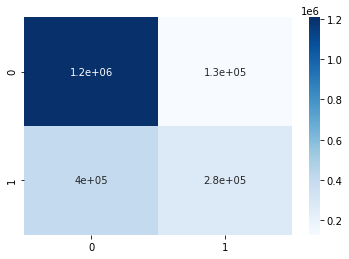

In [92]:
sns.heatmap(data=conf,annot=True, cmap='Blues')

In [86]:
accuracy_score(y_test, y_pred_copy)

0.7360356467942957

In [87]:
precision_score(y_test, y_pred_copy)

0.6833414302609173

In [88]:
recall_score(y_test, y_pred_copy)

0.40824930261466363

In [80]:
i=0.05
while i<1:
    y_pred_copy =np.copy(y_pred)
    y_pred_copy[y_pred_copy<i] = 0
    y_pred_copy[y_pred_copy>i] = 1
    print(accuracy_score(y_test, y_pred_copy), recall_score(y_test, y_pred_copy), i)
    i+=0.05

0.365947956790203 0.9983377089407512 0.05
0.4085388996187779 0.9820021079140593 0.1
0.48373389566980435 0.9391431431959671 0.15000000000000002
0.5625369751754742 0.8729226858753634 0.2
0.6272084770637474 0.7920963483833706 0.25
0.6740892834669312 0.707276994272865 0.3
0.7050701450665577 0.6238824610702868 0.35
0.7235371703944911 0.5454103029796641 0.39999999999999997
0.7327877771094307 0.47323256976418626 0.44999999999999996
0.7360356467942957 0.40824930261466363 0.49999999999999994
0.7347796056575858 0.3497290348304214 0.5499999999999999
0.7310045455311196 0.29826837352002594 0.6
0.7252000003963838 0.25135922344328787 0.65
0.7183425608176605 0.20958499892258914 0.7000000000000001
0.7109410844862321 0.17202367079014527 0.7500000000000001
0.703273040055573 0.1383043751676583 0.8000000000000002
0.6954796392511121 0.10767365737747933 0.8500000000000002
0.6875252075316884 0.07932089400182647 0.9000000000000002
0.6790242616608679 0.05139762910973613 0.9500000000000003
